<a href="https://colab.research.google.com/github/JaiSharma122/102116004-SESS-LE1/blob/main/102116004_JaiSharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

dataset_path = '/content/drive/MyDrive/dataset'


commands = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
commands.sort()
print(f"Commands: {commands}")
print(f"Number of commands:" , {len(commands)})

Commands: ['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
Number of commands: {36}


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


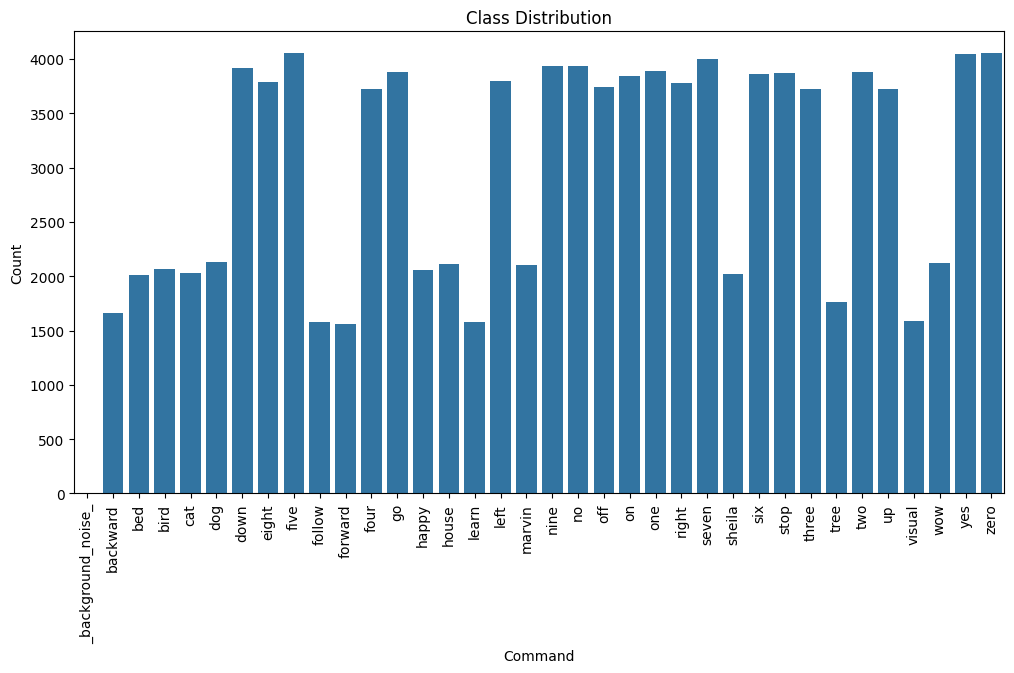

In [3]:
file_count_per_class = {command: len(os.listdir(os.path.join(dataset_path, command))) for command in commands}

df_class_distribution = pd.DataFrame(list(file_count_per_class.items()), columns=['Command', 'Count'])

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Command', y='Count', data=df_class_distribution)
plt.xticks(rotation=90)
plt.title('Class Distribution')
plt.show()


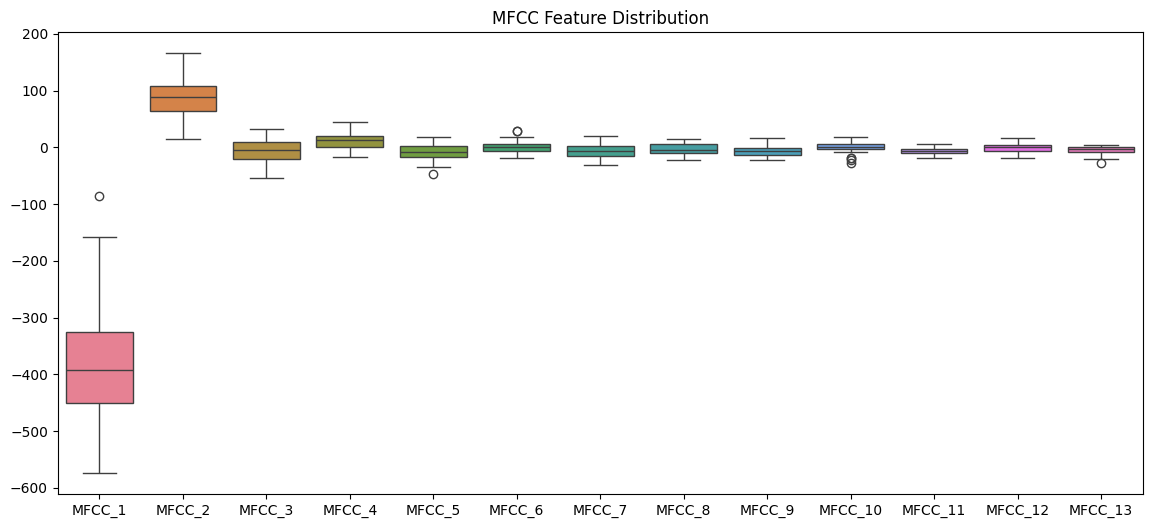

In [4]:
# Extract MFCCs for a sample from each class
mfccs = []
labels = []

for command in commands:
    folder_path = os.path.join(dataset_path, command)
    file_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs.append(np.mean(mfcc, axis=1))
    labels.append(command)

df_mfcc = pd.DataFrame(mfccs, columns=[f'MFCC_{i}' for i in range(1, 14)])
df_mfcc['Label'] = labels

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_mfcc.drop('Label', axis=1))
plt.title('MFCC Feature Distribution')
plt.show()


In [6]:
!pip install librosa tensorflow pandas matplotlib


In [5]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


# Hyperparameters
SAMPLE_RATE = 16000  # 16kHz sampling rate
N_MFCC = 13          # Number of MFCC features
AUDIO_DURATION = 1   # 1 second duration
N_CLASSES = 10       # Number of commands to classify (you can adjust)

# List of commands (update this list if you want to classify more/less commands)
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# Load and preprocess audio files
def load_audio_files(dataset_path, commands):
    X = []
    y = []
    for label in commands:
        folder_path = os.path.join(dataset_path, label)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            # Load the audio file and ensure it's the correct length
            y_audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=AUDIO_DURATION)
            # Extract MFCC features
            mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=N_MFCC)
            mfcc = np.mean(mfcc.T, axis=0)  # Take mean across time
            X.append(mfcc)
            y.append(label)
    return np.array(X), np.array(y)

# Load data
X, y = load_audio_files(dataset_path, commands)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize features
X_train = X_train / np.max(np.abs(X_train), axis=0)
X_test = X_test / np.max(np.abs(X_test), axis=0)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (30836, 13)
Test set size: (7710, 13)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build an improved neural network
def build_improved_model(input_shape, n_classes):
    model = Sequential()

    # 1D Convolutional Layer to extract features from time series (MFCC)
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(input_shape, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Another Conv1D Layer
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Flatten for fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))  # Increased dropout for regularization
    model.add(BatchNormalization())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(n_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the improved model
input_shape = X_train.shape[1]  # Assuming X_train is reshaped for Conv1D input
n_classes = len(commands)
model = build_improved_model(input_shape, n_classes)

# Print model summary
model.summary()

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 11, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 11, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 3, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,346 (399.79 KB)

 Trainable params: 101,066 (394.79 KB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/30
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.1798 - loss: 2.4321 - val_accuracy: 0.3393 - val_loss: 1.8253
Epoch 2/30
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2788 - loss: 1.9644 - val_accuracy: 0.3427 - val_loss: 1.7958
Epoch 3/30
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3058 - loss: 1.9252 - val_accuracy: 0.3562 - val_loss: 1.7804
Epoch 4/30
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.3112 - loss: 1.8998 - val_accuracy: 0.3535 - val_loss: 1.7734
Epoch 5/30
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.3135 - loss: 1.8965 - val_accuracy: 0.3650 - val_loss: 1.7759
Epoch 6/30
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3263 - loss: 1.8710 - val_accuracy: 0.3654 - val_loss: 1.7530
Epoch 7/30
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.3250 - loss: 1.8819 - val_accuracy: 0.3606 - val_loss: 1.7602
Epoch 8/30
1446/1446 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.3370 - loss:

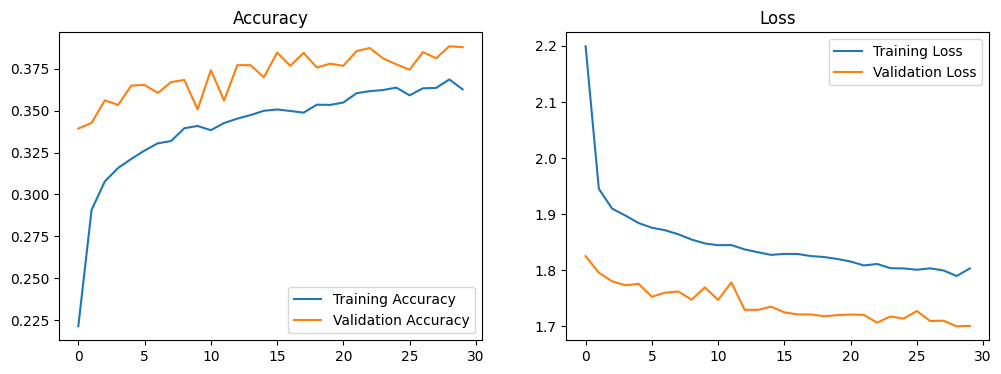

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.25)

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [11]:
model.save('speech_command.keras')

In [12]:
X_train_path = 'X_train.npy'
X_test_path = 'X_test.npy'
y_train_path = 'y_train.npy'
y_test_path = 'y_test.npy'

# Save the training and test data as numpy files
np.save(X_train_path, X_train)
np.save(X_test_path, X_test)
np.save(y_train_path, y_train)
np.save(y_test_path, y_test)